# Understanding and predicting payments of credit card users: k-means clustering and linear regression model

This notebook identifies clusters of credit card users, using **K-means clustering**. **Principal Components Analysis (PCA)** is used to reduce the dimensionality of the data. Dividing the users in clusters is useful, first, to understand credit patterns and, second, to create better market strategies.

On a second part, I predict the amount of payments done by the users based on features such as balance of their account, how frequently the Balance is updated, amount of purchases on the account, cash in advance given by the user, credit card limit, among others. After performing hyperparameter tuing, **Linear Regression model** with Ridge regularization proved to be the best model. 

In [31]:
import warnings
warnings.filterwarnings('ignore')

## Preprocessing

### _Load data_

In [32]:
import pandas as pd

# Load the training data set
df_train = pd.read_csv('./df_train.csv', header=0)
df_test = pd.read_csv('./df_test.csv', header=0)

print(df_train.shape)
print(df_test.shape)

(7160, 18)
(1790, 17)


In [33]:
# check uncommon columns
import numpy as np
np.setdiff1d(df_train.columns, df_test.columns)

array(['PAYMENTS'], dtype=object)

In [34]:
# Check the types of data per column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           7160 non-null   object 
 1   BALANCE                           7160 non-null   float64
 2   BALANCE_FREQUENCY                 7160 non-null   float64
 3   PURCHASES                         7160 non-null   float64
 4   ONEOFF_PURCHASES                  7160 non-null   float64
 5   INSTALLMENTS_PURCHASES            7160 non-null   float64
 6   CASH_ADVANCE                      7160 non-null   float64
 7   PURCHASES_FREQUENCY               7160 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        7160 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  7160 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            7160 non-null   float64
 11  CASH_ADVANCE_TRX                  7160 non-null   int64  
 12  PURCHA

In [35]:
df_train['PAYMENTS'].describe()

count     7160.000000
mean      1731.761665
std       2845.105467
min          0.000000
25%        381.352692
50%        855.799595
75%       1901.779401
max      39461.965800
Name: PAYMENTS, dtype: float64

In [36]:
df_train.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C17247,166.514439,0.777778,503.92,370.30,133.62,0.000000,0.777778,0.444444,0.666667,0.000000,0,14,2500.0,142.308045,130.127411,0.000000,9
1,C14706,3261.241461,1.000000,0.00,0.00,0.00,154.672040,0.000000,0.000000,0.000000,0.083333,1,0,6500.0,800.677168,1588.441785,0.000000,12
2,C18778,528.463885,1.000000,0.00,0.00,0.00,5191.738847,0.000000,0.000000,0.000000,0.833333,11,0,1000.0,4736.808799,309.547058,0.833333,12
3,C14587,24.831137,0.636364,1909.13,30.00,1879.13,0.000000,0.916667,0.083333,0.833333,0.000000,0,12,2000.0,1831.935279,21.095616,0.000000,12
4,C15864,3598.913061,1.000000,53.13,53.13,0.00,2767.233925,0.083333,0.083333,0.000000,0.250000,6,1,6000.0,868.558084,1233.962964,0.000000,12


In [37]:
# reset rcParams
#IPython_default = plt.rcParams.copy()
#plt.rcParams.update(IPython_default);

In [38]:
df_train.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

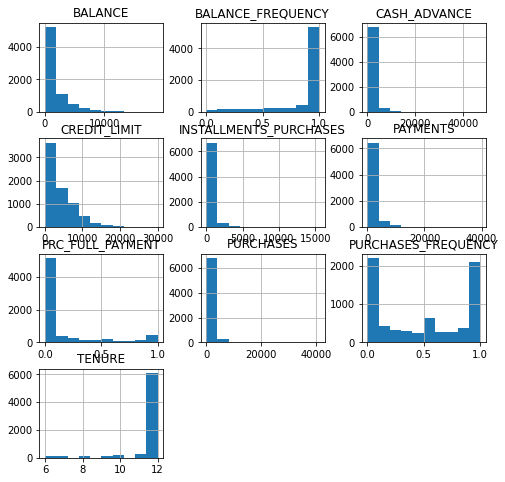

In [39]:
# print histograms to get a sense of the data and the distribution of selected features
%matplotlib inline
import matplotlib.pyplot as plt
df_train[['BALANCE','BALANCE_FREQUENCY','PURCHASES','INSTALLMENTS_PURCHASES','CASH_ADVANCE',
          'PURCHASES_FREQUENCY','CREDIT_LIMIT','PAYMENTS','PRC_FULL_PAYMENT', 'TENURE']].hist(figsize=(8,8))
plt.show()

### _Correlations_

In [40]:
# Check correlations of payments and percentage of full payment made by the user
corr_matrix = df_train.corr()
corr_matrix["PAYMENTS"].sort_values(ascending=False)

PAYMENTS                            1.000000
PURCHASES                           0.586822
ONEOFF_PURCHASES                    0.550576
CASH_ADVANCE                        0.488696
CREDIT_LIMIT                        0.416306
PURCHASES_TRX                       0.387055
INSTALLMENTS_PURCHASES              0.373572
BALANCE                             0.326770
CASH_ADVANCE_TRX                    0.276715
ONEOFF_PURCHASES_FREQUENCY          0.245032
CASH_ADVANCE_FREQUENCY              0.200476
MINIMUM_PAYMENTS                    0.127118
PRC_FULL_PAYMENT                    0.116513
TENURE                              0.105135
PURCHASES_FREQUENCY                 0.095212
PURCHASES_INSTALLMENTS_FREQUENCY    0.078182
BALANCE_FREQUENCY                   0.071872
Name: PAYMENTS, dtype: float64

In [41]:
corr_matrix["PRC_FULL_PAYMENT"].sort_values(ascending=False)

PRC_FULL_PAYMENT                    1.000000
PURCHASES_FREQUENCY                 0.302628
PURCHASES_INSTALLMENTS_FREQUENCY    0.249645
INSTALLMENTS_PURCHASES              0.196544
PURCHASES                           0.185184
PURCHASES_TRX                       0.158750
ONEOFF_PURCHASES_FREQUENCY          0.147637
ONEOFF_PURCHASES                    0.132651
PAYMENTS                            0.116513
CREDIT_LIMIT                        0.052769
TENURE                             -0.018595
BALANCE_FREQUENCY                  -0.100608
MINIMUM_PAYMENTS                   -0.137682
CASH_ADVANCE                       -0.150110
CASH_ADVANCE_TRX                   -0.164637
CASH_ADVANCE_FREQUENCY             -0.248850
BALANCE                            -0.318245
Name: PRC_FULL_PAYMENT, dtype: float64

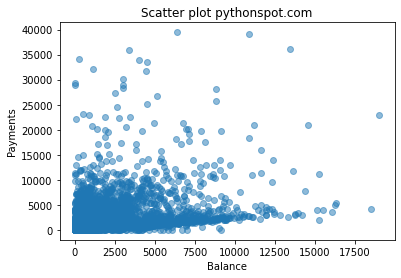

In [42]:
# Plot
x = df_train['BALANCE']
y = df_train['PAYMENTS']
plt.scatter(x, y,alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('Balance')
plt.ylabel('Payments')
plt.show()

## Prepare the data for Machine Learning Algorithms

### _Define the target_

In [43]:
target = 'PAYMENTS'

### _Create validation set_

In [44]:
from sklearn.model_selection import train_test_split

# Divide: 80% as training set and 20% as validation
df_train, df_valid = train_test_split(df_train, 
                                      train_size=.8, 
                                      random_state=42)

# Reset the index in training and validation sets
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(5728, 18)
(1432, 18)
(1790, 17)


### _Handle identifiers_

In [45]:
# define function
def id_checker(df):
    df_id = df[[var for var in df.columns 
                if df[var].nunique(dropna=True) == df[var].notnull().sum()]] 
    
    if df_id.shape[1]==0:
      return "The data has no identifiers."
    else:     
      return df_id

# Combine df_impute_train, df_impute_valid and df_impute_test
df = pd.concat([df_train, df_valid, df_test], sort=False)

# Call id_checker on df
df_id = id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

,CUST_ID
0,C12311
1,C17993
2,C15603
3,C14785
4,C11729


In [46]:
# Remove the identifiers from all sets
df_train = df_train.drop(columns=df_id.columns)
df_valid = df_valid.drop(columns=df_id.columns)
df_test = df_test.drop(columns=df_id.columns)

# Print the dimension of all sets
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(5728, 17)
(1432, 17)
(1790, 16)


### _Handle missing data_

In [47]:
def nan_checker(df):
    # Get the variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False)
    
    return df_nan

# Combine train, validation and test sets
df = pd.concat([df_train, df_valid, df_test], sort=False)

# Call nan_checker on df
df_miss = nan_checker(df)

# Print df_nan
df_miss.reset_index(drop=True)

,var,proportion,dtype
0,PAYMENTS,0.200000,float64
1,MINIMUM_PAYMENTS,0.034972,float64
2,CREDIT_LIMIT,0.000112,float64


There is missing data in "Minimum payments" and "credit limit". We can either remove the missing rows (because the percentage of missing values is very low), or we can impute the missing values. Let's impute the missing values of the columns by adding the mean value of each column.

_Note: the missing data of payments correspond to the test set, so this columns can simply be ignored._

In [48]:
from sklearn.impute import SimpleImputer

# The SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')

# Make a copy of df_train, df_valid and df_test
df_impute_train = df.iloc[:df_train.shape[0], :].copy(deep=True)
df_impute_valid = df.iloc[df_train.shape[0]:df_train.shape[0] + df_valid.shape[0], :].copy(deep=True)
df_impute_test = df.iloc[df_train.shape[0] + df_valid.shape[0]:, :].copy(deep=True)

# Impute the variables with missing values in df_impute_train, df_impute_valid and df_impute_test 
df_impute_train[df_miss['var']] = si.fit_transform(df_impute_train[df_miss['var']])
df_impute_valid[df_miss['var']] = si.transform(df_impute_valid[df_miss['var']])
df_impute_test[df_miss['var']] = si.transform(df_impute_test[df_miss['var']])

In [49]:
df_train = df_impute_train.copy(deep=False)
df_valid = df_impute_valid.copy(deep=False)
df_test = df_impute_test.copy(deep=False)

### _Scale the data_

In [50]:
from sklearn.preprocessing import StandardScaler, normalize

ss = StandardScaler()

df_ss_train = pd.DataFrame(ss.fit_transform(df_train), columns=df_train.columns)
df_ss_valid = pd.DataFrame(ss.transform(df_valid), columns=df_valid.columns)
df_ss_test = pd.DataFrame(ss.transform(df_test), columns=df_test.columns)

## K-means clustering

### _Prepare the dataframe_

In [51]:
# Let's combine the training and validation scaled sets 
scaled_df = pd.concat([df_train, df_valid], sort=False)

# normalize the data to omit impact of outliers
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

### _Reduce dimensions with Principal Component Analysis_

Let's reduce the number of dimensions to visualize the better the data.

In [52]:
from sklearn.decomposition import PCA

# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
#X_principal = pca.fit_transform(scaled_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']
X_principal.head()

,P1,P2
0,-0.316108,0.111925
1,-0.405571,-0.145823
2,-0.159898,-0.075645
3,0.437173,-0.129813
4,-0.328456,0.139440


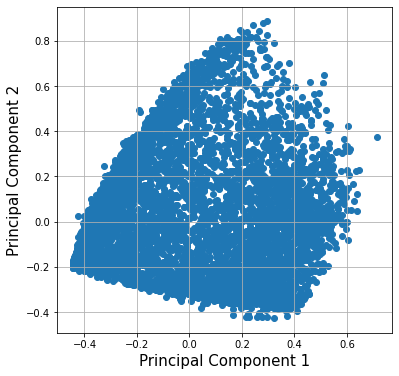

In [53]:
from sklearn.decomposition import PCA

# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
#X_principal = pca.fit_transform(scaled_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

# plot the components
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(X_principal['P1'], X_principal['P2'])
ax.grid()

### _Elbow criterion for determining k_

This method helps us to determine an ideal number of clusters based on the sum of the squared distance (SSE). [Source](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a). We found between 3 and 4 clusters.

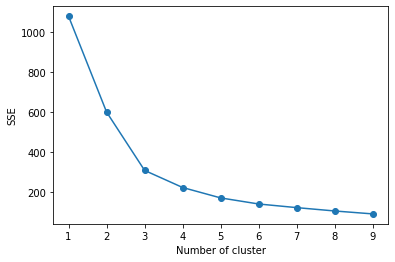

In [54]:
from sklearn.cluster import KMeans

# Function to plot the number of clusters vs SSE
def plot_elbow(X_principal=X_principal):
  sse = {}
  for k in range(1, 10):
      kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_principal)
      sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
  plt.figure()
  plt.plot(list(sse.keys()), list(sse.values()),'-o')
  plt.xlabel("Number of cluster")
  plt.ylabel("SSE")
  plt.show()

plot_elbow()

### _Find clusters_

In [55]:
def clusters(X_principal, clusters):
  kmeans = KMeans(n_clusters=clusters)
  kmeans.fit(X_principal)
  centroids = kmeans.cluster_centers_

  # Visualizing the clusters 
  plt.scatter(X_principal['P1'], X_principal['P2'], 
              c = KMeans(n_clusters = clusters).fit_predict(X_principal), cmap =plt.cm.winter) 
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, c='r', label='centroid')
  plt.show() 


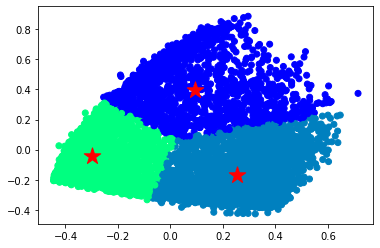

In [56]:
clusters(X_principal, clusters=3)

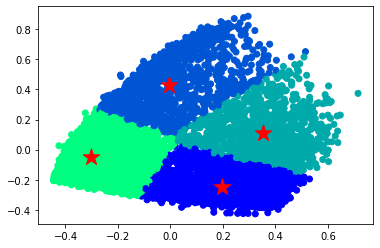

In [57]:
clusters(X_principal, clusters=4)

## Regression analysis with hyperparameter tuning

### _Define the feature matrix_

In [58]:
# Get the feature matrix
X_train = df_ss_train[np.setdiff1d(df_ss_train.columns, [target])]
X_valid = df_ss_valid[np.setdiff1d(df_ss_valid.columns, [target])]
X_test = df_ss_test[np.setdiff1d(df_ss_test.columns, [target])]

# Get the target vector
y_train = df_ss_train[target]
y_valid = df_ss_valid[target]

### _Dictionary of the models_

In [59]:
# Dictionary of models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

models = {'lr': LinearRegression(),
          'lasso': Lasso(random_state=42),
          'ridge': Ridge(random_state=42),
          'en': ElasticNet(random_state=42)}

### _Define the pipeline_

In [60]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

### _Predefined cross-validator_

In [61]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = pd.concat([X_train, X_valid], ignore_index=True, sort=False)

# Combine the target vector in the training and validation data
y_train_valid = pd.concat([y_train, y_valid], ignore_index=True, sort=False)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

### _Grid search_

In [65]:
param_grids = {}

# Linear regression
# Not essential to tune this since LR is based on a close formed of the Normal Equation
param_grids['lr'] = [{}]

# Lasso
alpha_grids = [10 ** i for i in range(-4, 5)]
param_grids['lasso'] = [{'model__alpha': alpha_grids}]

# Ridge
alpha_grids = [10 ** i for i in range(-4, 5)]
param_grids['ridge'] = [{'model__alpha': alpha_grids}]

# Elastic net
alpha_grids = [10 ** i for i in range(-4, 5)]
l1_ratio_grids = [0.1 * i for i in range(11)]
param_grids['en'] = [{'model__alpha': alpha_grids,
                      'model__l1_ratio': l1_ratio_grids}]

In [66]:
# Create the directory to store results of Grid Search
import os

# Make directory
directory = os.path.dirname('./cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

### _Hyperparameter tuning_

In [67]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='neg_mean_squared_error',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='./cv_results/GridSearchCV/' + acronym + '.csv', index=False)

### _Model selection_

In [68]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
df_scores = pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])
df_scores

,best_score,best_param,best_estimator
0,-0.341289,{'model__alpha': 100},"(Ridge(alpha=100, copy_X=True, fit_intercept=T..."
1,-0.341610,"{'model__alpha': 0.01, 'model__l1_ratio': 0.0}","(ElasticNet(alpha=0.01, copy_X=True, fit_inter..."
2,-0.342082,{'model__alpha': 0.001},"(Lasso(alpha=0.001, copy_X=True, fit_intercept..."
3,-0.342215,{},"(LinearRegression(copy_X=True, fit_intercept=T..."
